# Bayesian nonlinear regression

Last modified: 15/04/2025 by weipeng

In [6]:
import numpy as np

import jax
import jax.scipy.stats as stats
import jax.numpy as jnp

import blackjax

from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

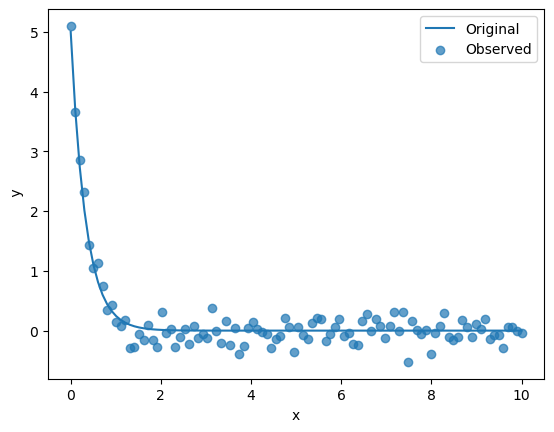

In [7]:
# generate observed data
true_t1 = 5
true_t2 = 3
noise_sigma = 0.2

x = np.linspace(0,10,100)
y = true_t1 * np.exp(-true_t2 * x)
y_noise = y + np.random.normal(0, noise_sigma, len(x))

plt.plot(x, y, label="Original")
plt.scatter(x, y_noise, alpha=0.7, label="Observed")
plt.xlabel("x"), plt.ylabel(" y")
plt.legend()
plt.show()

In [8]:
# Plot
def post(mcmc_samples):
    print(jnp.mean(jnp.array(mcmc_samples),axis=0))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(mcmc_samples[:, 0], label="w0")
    plt.plot(mcmc_samples[:, 1], label="w1")
    plt.title("MCMC trace")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], alpha=0.1)
    plt.xlabel("w0"), plt.ylabel("w1")
    plt.title("Joint post")
    plt.show()

In [9]:
# prior of w
mu_prior = np.zeros(2) 
Sigma_prior = 10 * np.eye(2)

def log_piror(theta):
    return stats.multivariate_normal.logpdf(theta, mean=mu_prior, cov=Sigma_prior)

def log_likelihood(theta):
    mu = theta[0] * jnp.exp(-theta[1] * x)
    cov_matrix = (noise_sigma ** 2) * jnp.eye(len(mu))
    return stats.multivariate_normal.logpdf(y_noise, mean=mu, cov=cov_matrix)

def log_posterior(theta):
    return log_likelihood(theta) + log_piror(theta)

100%|███████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3526.19it/s]


[5.078529  2.9452307]


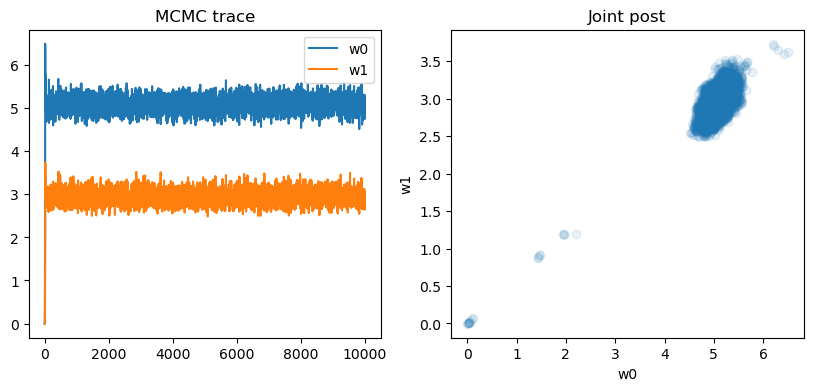

In [10]:
# Sampling with NUTS
rng_key = jax.random.key(42)

step_size = 0.01
inverse_mass_matrix = jnp.ones(2)
nuts = blackjax.nuts(log_posterior, step_size, inverse_mass_matrix)
kernel = jax.jit(nuts.step)

initial_position = jnp.zeros(2)
state = nuts.init(initial_position)

states = []
for _ in tqdm(range(10000)):
    rng_key, sub_key = jax.random.split(rng_key)
    state, info = kernel(sub_key, state)
    states.append(state.position)
post(jnp.array(states))